# INF8801 - LAB 1
# CBIR and indexing

Welcome to the first lab of INF8801 ! Today, we are going to implement the VLAD (Vector of Locally Aggregated Descriptors) method for content-based image retrieval (CBIR). We will use a custom subset of the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) as well as the test set from the [MalayaKew plant dataset](https://web.fsktm.um.edu.my/~cschan/downloads_MKLeaf_dataset.html).

The goal of this lab is to implement a CBIR system that can retrieve images of dogs from a database, given a query image. We try to create a good representation of images using features extracted with SIFT and ORB. We then use the VLAD algorithm to create a vector representation of each image. Finally, we use the cosine similarity to compare the query image with the images in the database and retrieve similar images.

We'll compare the different methods and critically analyze the results. In light of the recent advancements in deep learning, the original VLAD has fallen mostly out of favor, along with the descriptors on which it is based... However, some of its variants like the deep learning-based [NetVLAD](https://www.di.ens.fr/willow/research/netvlad/) are still used in certain types of tasks like Visual Place Recognition. Most of the other tasks, like CBIR with Google Lens, have been trivialized by large and complex models trained on literal billions of images. Regardless of its actual performance, VLAD is also a pretext to introduce standard tools and methods for computer vision : a lot of the underlying reasonings are still relevant (e.g. why do we resort to clustering? How do we find the right size for the codebook?). 

Note that in recent years, there has been a massive proliferation of articles, most of them exploring wildly different methods or approaches. Apart from certain key papers or architectures (looking at you, transformers), there are few perennial must-read articles, as the top ;ethods get steadily replaced by even better ones. The field is moving very fast, and one of the most important skills is having diverse enough knowledge to quickly grasp new papers. This is why you'll still benefit from learning about classical methods like VLAD. If you understand them, you'll be able to quickly grasp derivatives like NetVLAD, and it also means that you will have a quicker understanding of any paper that resorts to say, clustering, bag-of-words, k-means, etc.

To understand VLAD, either read [the original paper](https://inria.hal.science/inria-00548637/file/jegou_compactimagerepresentation.pdf), find some tutorials online, or refer to the slides available on Moodle and that I present(ed) at the beginning of class.

---

We ask you to implement / finish implementing the following methods / functions :
- `VLAD`
- `precision`
- `composite_distance`

You are encouraged to add prints or similar to help you understand how it all works, what shape are the different variables, etc. Just don't break the source code, or modify how it works.
There are also numerous question disseminated in the notebook. Answer them directly in the notebook, and be careful : it is not that easy to get the full marks on them.

---


Please rename the file with both or your last names.

In [1]:
from scipy.io import loadmat
from os.path import join
from os import listdir
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans
from sklearn.neighbors import BallTree
from tqdm.notebook import tqdm
import itertools
import pickle

# THE DATASETS
You don't have to do anything in this section. The code defines the classes `DogBreeds` and `MalayaKewLeaves` which will be used to load the images and the labels.

In [3]:
class DogBreeds():
    """Class to load the StanfordDogs dataset / subset and extract the descriptors."""

    def __init__(self, dataset_dirpath: str='./dog-breeds-2') -> None:
        # reference images (the dataset)
        references_dirpath = join(dataset_dirpath, 'references')
        self.label_names = listdir(references_dirpath) # the breeds
        self.reference_img_paths = [join(references_dirpath, breed, image) 
                             for breed in self.label_names 
                             for image in listdir(join(references_dirpath, breed))]
        self.reference_labels = [self._get_label(img_path) for img_path in self.reference_img_paths]

        # query images (taken from the references and eventually modified)
        queries_dirpath = join(dataset_dirpath, 'queries')
        self.query_img_paths = [join(queries_dirpath, image) for image in listdir(queries_dirpath)]
        self.query_labels = [self._get_label(img_path) for img_path in self.query_img_paths]

    def __len__(self) -> int:
        return len(self.reference_img_paths)

    def __getitem__(self, index: int) -> np.ndarray:
        return self.get_reference(index)
    
    def get_reference(self, index: int) -> np.ndarray:
        """Get an image from the reference dataset."""
        img = cv2.imread(self.reference_img_paths[index])
        label = self.reference_labels[index]
        return img, label
    
    def get_query(self, index: int) -> np.ndarray:
        """Get an image from the query dataset."""
        img = cv2.imread(self.query_img_paths[index])
        label = self.query_labels[index]
        return img, label

    def _get_label(self, img_path: str) -> int :
        """Extract the label (as an int) of an image, which is the dog's breed, based on its name."""
        # Get filename without extension
        name = img_path.split('/')[-1].split('.')[0].split('_')[0]
        # Remove digits from the name
        name = re.sub(r'\d', '', name)
        return self.label_names.index(name)

class MalayKewLeaves():
    """Class to load the MalayKew dataset / subset and extract the descriptors."""

    def __init__(self, dataset_dirpath: str='./leaves') -> None:
        # reference images (the dataset)
        references_dirpath = join(dataset_dirpath, 'references')
        self.label_names = listdir(references_dirpath)
        self.reference_img_paths = []
        self.reference_labels = []
        for i,species in enumerate(self.label_names):
            for image in listdir(join(references_dirpath, species)):
                self.reference_img_paths.append(join(references_dirpath, species, image))
                self.reference_labels.append(i)

        # query images (taken from the references and eventually modified)
        queries_dirpath = join(dataset_dirpath, 'queries')
        self.query_img_paths = [join(queries_dirpath, img_name) for img_name in listdir(queries_dirpath)]
        self.query_labels = [self.label_names.index(img.split('/')[-1].split('.')[0]) for img in self.query_img_paths]

    def __len__(self) -> int:
        return len(self.reference_img_paths)
    
    def __getitem__(self, index: int) -> np.ndarray:
        return self.get_reference(index)
    
    def get_reference(self, index: int) -> np.ndarray:
        """Get an image from the reference dataset."""
        img = cv2.imread(self.reference_img_paths[index])
        label = self.reference_labels[index]
        return img, label
    
    def get_query(self, index: int) -> np.ndarray:
        """Get an image from the query dataset."""
        img = cv2.imread(self.query_img_paths[index])
        label = self.query_labels[index]
        return img, label
    
    

Running this cell displays a random selection of 6 images from the dataset.

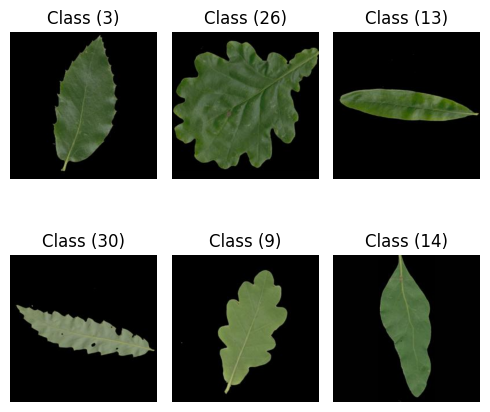

In [4]:
dataset = MalayKewLeaves()
plt.rcParams['figure.figsize'] = [5, 5]
fig, axs = plt.subplots(2, 3)
examples = np.random.choice(len(dataset), 6)
for i in range(2):
    for j in range(3):
        img, label = dataset[examples[i*3+j]]
        axs[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i, j].set_title(dataset.label_names[label])
        axs[i, j].axis('off')
        
plt.tight_layout()


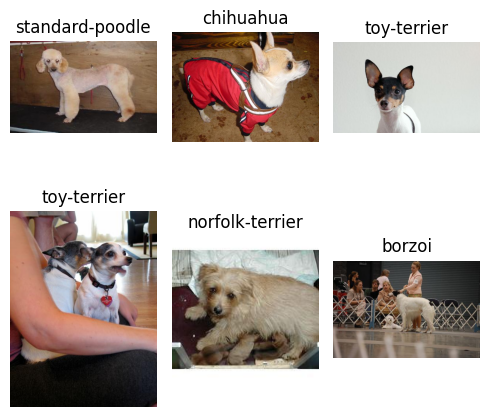

In [5]:
dataset = DogBreeds()
plt.rcParams['figure.figsize'] = [5, 5]
fig, axs = plt.subplots(2, 3)
examples = np.random.choice(len(dataset), 6)
for i in range(2):
    for j in range(3):
        goodboi, label = dataset[examples[i*3+j]]
        axs[i, j].imshow(cv2.cvtColor(goodboi, cv2.COLOR_BGR2RGB))
        axs[i, j].set_title(dataset.label_names[label])
        axs[i, j].axis('off')
        
plt.tight_layout()

# SOURCE CODE
Those two descriptors are available for you to try and compare.

In [6]:
def describeSIFT( image):
    """Doc at https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html"""
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(image,None)
    return kp, des

def describeORB( image):
    """Doc https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html
    An efficient alternative to SIFT or SURF
    ORB is basically a fusion of FAST keypoint detector and BRIEF descriptor 
    with many modifications to enhance the performance"""
    orb = cv2.ORB_create()
    kp, des = orb.detectAndCompute(image,None)
    return kp, des

### CODE :

Complete the VLAD function below. Given the descriptors for the entire dataset :
- For every cluster in the dictionary :
    - If there is at least one descriptor in this cluster :
        - Compute the sum of [the difference between each descriptor inside the cluster and the center of the cluster]. Progessively fill out a [number of clusters, descriptor size] matrix with these results
- Normalize the resulting vector of size (number of clusters * descriptor size) with power normalization
- Normalize the vector with the L2 norm
- return the matrix


In [20]:
def choose_function(mode: str) -> callable:
    """String to function handle
    Supports 'sift' and 'orb' """
    mode = mode.lower()
    if mode=="sift":
        desc_function = describeSIFT
    elif mode=="orb":
        desc_function = describeORB
    else:
        raise ValueError('Invalid descriptor mode')
    return desc_function

def get_descriptors(dataset, mode: str='sift') -> np.ndarray:
    """Extract the descriptors from the dataset."""
    desc_function = choose_function(mode)
    descriptors = list()
    for path in tqdm(dataset.reference_img_paths, desc="Extracting descriptors"):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, desc = desc_function(img)
        assert desc is not None, f'Well, that is unusual. No descriptors found in image {path}.'
        descriptors.append(desc)
    # flatten list
    descriptors = list(itertools.chain.from_iterable(descriptors))
    # list to array
    descriptors = np.asarray(descriptors)

    return descriptors

def kmeans_dictionary(training: np.ndarray, n_clusters: int) -> KMeans:
    """Clusters the descriptors using k-means"""
    est = KMeans(n_clusters, init='k-means++', tol=0.0001).fit(training)
    return est

def get_VLAD_descriptors(dataset: DogBreeds, dictionary: np.ndarray, mode: str='sift') -> np.ndarray:
    """Extract the VLAD descriptors from the dataset."""
    desc_function = choose_function(mode)
    
    descriptors=list()
    for image_path in tqdm(dataset.reference_img_paths, desc="Extracting VLAD descriptors"):
        im = cv2.imread(image_path)
        _, current_desc = desc_function(im)
        assert current_desc is not None, 'Well that is unusual. No descriptors found.'
        vlad_desc = VLAD(current_desc, dictionary)
        descriptors.append(vlad_desc)
                    
    #list to array    
    descriptors = np.asarray(descriptors)
    return descriptors

def VLAD(X: np.ndarray, dictionary: KMeans) -> np.ndarray:
    """Compute the VLAD descriptor from the descriptors and the k-means dictionary.
    
    Args:
        X: the descriptors from one image, shape [n_descriptors, descriptor_dimension]
        dictionary: k-means dictionary of visual words
    Returns:
        VLAD descriptor, shape [k*descriptor_dimension]
    """
    
    predicted_labels = dictionary.predict(X)
    centers = dictionary.cluster_centers_
    k = dictionary.n_clusters
    d = X.shape[1]  # Dimension des descripteurs

    vlad = np.zeros((k, d), dtype=np.float32)


    for i in range(k):

        indices = np.where(predicted_labels == i)[0]
        
        if len(indices) > 0:

            residuals = X[indices] - centers[i]
            vlad[i] = np.sum(residuals, axis=0)

    #  normalisation de puissance
    vlad = np.sign(vlad) * np.sqrt(np.abs(vlad))

    # Normalisation L2
    vlad = vlad.flatten()  #  matrice to vecteur
    vlad /= np.linalg.norm(vlad, ord=2) + 1e-12 

    return vlad

def retrieve(query: np.ndarray, k: int, mode: str, dictionary: np.ndarray, tree: BallTree) -> tuple:
    """Retrieve the k most relevant images from the dataset given a query image."""
    desc_function = choose_function(mode)

    #compute descriptor
    _, query_desc = desc_function(query)

    # compute VLAD
    vlad_desc = VLAD(query_desc, dictionary)

    #find the k most relevant images
    dist, ind = tree.query(vlad_desc.reshape(1,-1), k)    

    return dist, ind

# STEP-BY-STEP COMPUTATION

## Compute the descriptors for the dataset

In [21]:
descriptors = get_descriptors(dataset, 'sift')

Extracting descriptors:   0%|          | 0/1160 [00:00<?, ?it/s]

> **QUESTION :**
>
> Check how much the number of descriptors computed from each image can vary. How can we compare different images when their descriptor sizes are not even the same ? How does the VLAD pipeline solve this issue?

## Build a visual dictionary

In [22]:
k = 16

dictionary = kmeans_dictionary(descriptors, k)

## Compute VLAD descriptors

In [23]:
k = 16

vlad_descriptors = get_VLAD_descriptors(dataset, dictionary, 'sift')

Extracting VLAD descriptors:   0%|          | 0/1160 [00:00<?, ?it/s]

> **QUESTION :**
>
>Read the function `get_VLAD_descriptors`. Explain why we compute the VLAD descriptors again for the whole dataset, instead of using the list of descriptors previously obtained. Can you find a few simple optimizations that would allow us to compute the descriptors only once ? *(Note : implementing them is not necessary)*

> **QUESTION :**
>
> What is the point of the L2 normalization of the descriptors, from a mathematical standpoint? Could we just ignore it?

VLAD produces high-dimensional feature vectors, but their magnitudes can vary widely.
- Some images may produce stronger descriptor magnitudes due to more keypoints or richer textures.
Without normalization, images with higher magnitude VLAD vectors could unfairly dominate the similarity computation.
- Since L2-normalized vectors have unit norm, their cosine similarity is simply the dot product.

No, we should not ignore L2 normalization
L2 normalization ensures fair comparison of images, reduces bias due to scale differences, and improves retrieval performance.

## Create an index

In [24]:
leaf_size = 40

tree = BallTree(vlad_descriptors, leaf_size)   

> **QUESTION :**
>
> Why do we use a ball tree? When is it necessary? Is it necessary in our case?

## Comparing the results

> **CODE :**
>
>Complete the functions `precision` and `composite_distance` below.

In [25]:
def precision(match_indices: list, query_label: int) -> float:
    """Compute the precision of the retrieveal, i.e. the percentage of retrieved images that have the correct label.
    
    Args:
        match_indices: the indices of the retrieved images
        query_label: the label of the query image
    Returns:
        The precision of the retrieval
    """
    ##########################################################################################################
    ########################################## COMPLETE THE CODE #############################################
    ##########################################################################################################

def composite_distance(match_distances: list) -> float:
    """Compute a composite distance metric from the distances of the matches. You are encouraged to add a weighting scheme
    to grant more importance to the first matches. This should lessen the impact of the number of retrieved images on the
    metric score.
    
    Args:
        match_distances: the distances of the retrieved images
    Returns:
        The composite distance
    """
    ##########################################################################################################
    ########################################## COMPLETE THE CODE #############################################
    ##########################################################################################################

> **QUESTION :**
>
>List one advantage of each over the other.
>
>Can two descriptor types be compared using the precision metric? The composite distance metric?

## Testing the system

In [ ]:
nb_retrieved = 10
k = 16

plt.rcParams['figure.figsize'] = [20, 10]

for q in range(5):
    query, query_label = dataset.get_query(q)
    dist, ind = retrieve(query, nb_retrieved, 'sift', dictionary, tree)

    fig, axs = plt.subplots(1, nb_retrieved+1)
    axs[0].imshow(cv2.cvtColor(query, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Query : \n' + dataset.label_names[query_label])
    axs[0].axis('off')
    for i in range(nb_retrieved):
        img, label = dataset.get_reference(ind[0][i])
        axs[i+1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i+1].set_title(f'Match {i+1} : \n{dataset.label_names[label]}')
        axs[i+1].axis('off')
    plt.show()

print(f"Precision at {nb_retrieved} retrieved images: {precision(ind[0], query_label)}")
print(f"Composite distance: {composite_distance(dist[0])}")

# SANDBOX
We provide a sandbox with the basic pipeline already written, as well as some plotting. You can use it to test your code, ducplicate it to change the values and keep the displays, etc. Be careful, the processing time can get out of hand when increasing the number of clusters and the dataset size.

In [ ]:
descriptor_type = 'sift'
nb_clusters = 64
leaf_size = 40

dataset = MalayKewLeaves()
descriptors = get_descriptors(dataset, descriptor_type)
dictionary = kmeans_dictionary(descriptors, nb_clusters)
vlad_descriptors = get_VLAD_descriptors(dataset, dictionary, descriptor_type)
tree_index = BallTree(vlad_descriptors, leaf_size)

with open(f'tree_{nb_clusters}clusters_{descriptor_type}desc.pickle', 'wb') as f:
    pickle.dump(tree_index, f)


In [ ]:
nb_retrieved = 10
nb_queries = 5

with open(f'tree_{nb_clusters}clusters_{descriptor_type}desc.pickle', 'rb') as f:
    tree_index = pickle.load(f)

mean_prec = 0
mean_dist = 0


plt.rcParams['figure.figsize'] = [20, 11]
fig, axs = plt.subplots(nrows=nb_queries, ncols=nb_retrieved+1)

for q in range(nb_queries):
    query, query_label = dataset.get_query(q)
    dist, ind = retrieve(query, nb_retrieved, descriptor_type, dictionary, tree_index)

    axs[q,0].imshow(cv2.cvtColor(query, cv2.COLOR_BGR2RGB))
    axs[q,0].set_title('Query : \n' + dataset.label_names[query_label])
    axs[q,0].axis('off')
    for i in range(nb_retrieved):
        img, label = dataset.get_reference(ind[0][i])
        axs[q,1+i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[q,1+i].set_title(f'Match {i+1} : \n{dataset.label_names[label]}')
        axs[q,1+i].axis('off')

    mean_prec += precision(ind[0], query_label)
    mean_dist += composite_distance(dist[0])


print(f"Mean precision at {nb_retrieved} retrieved images: {mean_prec/nb_queries}")
print(f"Mean composite distance: {mean_dist/nb_queries}")


In [ ]:
# compare descriptor matches between the latest query and the second best retrieved image
kp_query, desc_query = describeSIFT(query)
kp_img, desc_img = describeSIFT(dataset.get_reference(ind[0][1])[0])

matcher = cv2.BFMatcher()
matches = matcher.match(desc_query, desc_img)

# Sort the matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw the matches
matched_img = cv2.drawMatches(query, kp_query, dataset.get_reference(ind[0][1])[0], kp_img, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


> **QUESTION :**
>
>Run the code with 5 increasing values for the number of clusters. What can you say about how the number of clusters affect retrieval, and why? [Expecting one major observation]

> **QUESTION :**
>
>Change the type of "backbone" descriptor. To what extent does it influence the results? What then are the advantages of using one over the other? [Expecting two or more]

> **QUESTION :**
>Change the dataset. What do you observe? Can you explain why some datasets and tasks necessarily end up yielding worse precision scores through VLAD? (Hint : think about what the descriptors actually represent in an image. The matching above can give you some insights.) [Expecting three arguments or more]

> **QUESTION :**
>
>A word about classification : recent neural-network based methods have shown that it is possible to achieve better results than the ones obtained with the VLAD method. For instance, the [latest architectures tested on the entire Stanford Dogs dataset](https://paperswithcode.com/sota/fine-grained-image-classification-on-stanford-1) reach more than 93% accuracy. What are the advantages of the VLAD method compared to neural-network based methods, in a CBIR context ? What are the inherent disadvantages for the specific task of dog breed classification?

### Side note :

The metrics we use to optimize our systems, in CBIR like everywhere else, are a reflection on our objective on the task. 

We often use metrics like precision and recall to measure the performance of our systems. If you want to find dog pictures with the same breed as your query, then precision is a great metric, but only because you have the right labels (the dog breed). If you want to find pictures of dogs in the same position as the query (e.g. a dog squeezing its head between hands), then breed is irrelevant and you'd have to label your dataset with the position of the dog. It's a neverending task.

Now for the leaves, the precision metric tells us our method isn't good, and in some capacity it is true : the retrieved species are often incorrect. Part of the reason is that, well, the method itself is a bit outdated. However, while the retrieved dogs didn't even look like one another, all the retrieved leaves *look* very similar, at least to the untrained eye. Unfortunately, the precision metric does not reflect that at all. Several deep learning methods have been proposed to address this issue (although they fall out of the scope of this lab), and are widely used for tasks pertaining to image generation for instance. They are known as [perceptual losses](https://deepai.org/machine-learning-glossary-and-terms/perceptual-loss-function) and are supposed to reflect how much a human would have considered the images similar.